# Runners

@[Chaoming Wang](https://github.com/chaoming0625)
@[Xiaoyu Chen](mailto:c-xy17@tsinghua.org.cn)

## Runners for Dynamical Systems

The convenient simulation interfaces for dynamical systems in BrainPy are implemented in ``brainpy.simulation.runner``. Currently, we implement three kinds of runner: ``ReportRunner``, ``StructRunner``, and ``DSRunner``. They have their respective advantages. 

In [1]:
import brainpy as bp

bp.math.set_platform('cpu')

## Initialize a runner

Generally, we can initialize a runner with the format of:

```python
SomeRunner(target=instance_of_dynamical_system,
           inputs=inputs_for_target_variables,
           monitors=interested_variables_to_monitor,
           dyn_vars=dynamical_changed_variables,
           jit=enable_jit_or_not)
```

- ``target`` specifies the simulation target. It must an instance of [brainpy.DynamicalSystem](../apis/auto/simulation/generated/brainpy.simulation.brainobjects.DynamicalSystem.rst). 
- ``monitors`` is used to define the interested variables in the model. During the simulation, the history values of the monitored variables will be recorded. 
- ``inputs`` is used to define the input operations for the specific variables. 
- ``dyn_vars`` is used to specify all the dynamically changed variables used in the ``target`` model.
- ``jit`` specifies whether enable the [JIT compilation](../tutorial_math/compilation.ipynb) during the simulation.

The usage of both ``monitors`` and ``inputs`` will be detailed in the next tutorial: [monitors and inputs](./monitors_and_inputs.ipynb).

Here we define a simualtion target, an E/I balanced network model. 

In [2]:
class EINet(bp.Network):
  def __init__(self, num_exc=3200, num_inh=800, method='exp_auto'):
    # neurons
    pars = dict(V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.)
    E = bp.models.LIF(num_exc, **pars, method=method)
    I = bp.models.LIF(num_inh, **pars, method=method)
    E.V[:] = bp.math.random.randn(num_exc) * 2 - 55.
    I.V[:] = bp.math.random.randn(num_inh) * 2 - 55.

    # synapses
    E2E = bp.models.ExpCOBA(E, E, bp.conn.FixedProb(prob=0.02),
                            E=0., g_max=0.6, tau=5., method=method)
    E2I = bp.models.ExpCOBA(E, I, bp.conn.FixedProb(prob=0.02),
                            E=0., g_max=0.6, tau=5., method=method)
    I2E = bp.models.ExpCOBA(I, E, bp.conn.FixedProb(prob=0.02),
                            E=-80., g_max=6.7, tau=10., method=method)
    I2I = bp.models.ExpCOBA(I, I, bp.conn.FixedProb(prob=0.02),
                            E=-80., g_max=6.7, tau=10., method=method)

    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

## ``brainpy.ReportRunner``

``brainpy.ReportRunner`` aims to provide a Pythonic interface for model debugging. Users can use the standard Python debugging tools when simulating the model with ``ReportRunner``. Moreover, it can report the simulation progress of the target model. 

The disadvantage of the ``brainpy.ReportRunner`` is that it is relatively slow. It iterates the loop along times during the simulation.

In [3]:
net = EINet()

runner = bp.ReportRunner(net, 
                         monitors=['E.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)],
                         jit=True)
runner.run(100.)

Compilation used 0.4325 s.
Start running ...
Run 10.0% used 0.089 s.
Run 20.0% used 0.181 s.
Run 30.0% used 0.276 s.
Run 40.0% used 0.369 s.
Run 50.0% used 0.459 s.
Run 60.0% used 0.553 s.
Run 70.0% used 0.644 s.
Run 80.0% used 0.734 s.
Run 90.0% used 0.828 s.
Run 100.0% used 0.919 s.
Simulation is done in 0.919 s.



0.9190351963043213

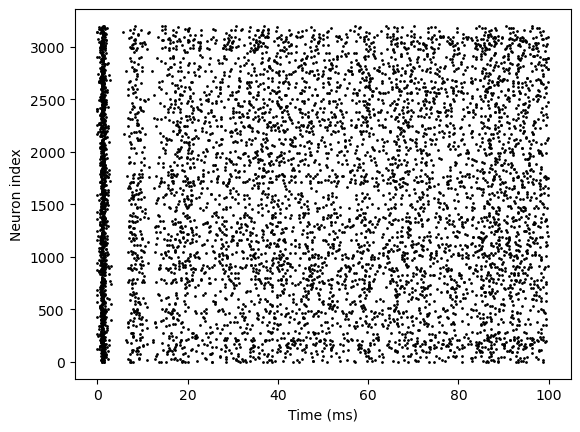

In [4]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)

## ``brainpy.StructRunner``

``brainpy.StructRunner`` aims to provide the compelling performance for model simulation. It takes advantage of the [structural loop primitive](../tutorial_math/control_flows.ipynb) to lower the model onto the XLA devices. 

However, the disdvantage of the ``brainpy.StructRunner`` is that it can not report the running progress during the specific simualtion period. Therefore, it is better to split a long simulation into several short durations. 

In [5]:
net = EINet()

runner = bp.StructRunner(net, 
                         monitors=['E.spike'],
                         inputs=[('E.input', 20.), ('I.input', 20.)],
                         jit=True)
runner.run(100.)

0.7870616912841797

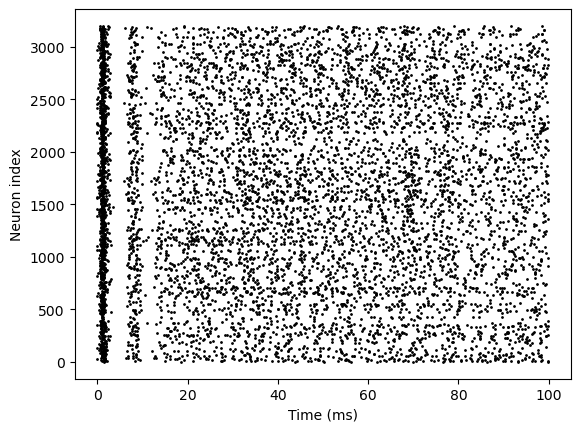

In [6]:
bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], show=True)

## ``brainpy.DSRunner``